# Research Question 1: River extent of influence

What is the spatial extent of influence of the river contribution to surface waters in the CAA?
- Does the RCD span full straits in the CAA? If so, which and during all seasons or only for a portion of the year?
- How long does it take for river contributions in the central CAA to reach Baffin Bay?

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
import os
from itertools import compress
import datetime as dt

%matplotlib inline

### Set region:

In [2]:
imin, imax = 1480, 2050
jmin, jmax = 160, 800

##### Load domain dimensions for reference:

In [3]:
mask  = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask = np.array(mask.variables['tmask'])
cond = (tmask[0,:,:,:] > 0.1) 
land_mask = np.ma.masked_where(cond, tmask[0,:,:,:]) 
tmask = tmask[0,:,imin:imax,jmin:jmax]

In [4]:
e1t_base = np.array(mask.variables['e1t'])[0,imin:imax,jmin:jmax]
e1v_base = np.array(mask.variables['e1v'])[0,imin:imax,jmin:jmax]
e2t_base = np.array(mask.variables['e2t'])[0,imin:imax,jmin:jmax]
e2u_base = np.array(mask.variables['e2u'])[0,imin:imax,jmin:jmax]
e3t = np.array(mask.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]

e1t = np.empty_like(e3t); e1t[:] = e1t_base
e1v = np.empty_like(e3t); e1v[:] = e1v_base
e2t = np.empty_like(e3t); e2t[:] = e2t_base
e2u = np.empty_like(e3t); e2u[:] = e2u_base

Calculate the e3v and e3u:

In [5]:
e3t = np.array(mask.variables['e3t_0'])[0,:,:,:]

e3v = np.zeros_like(e3t)
e3u = np.zeros_like(e3t)
for layer in range(50):
    for i in range(imin-5, imax+5):
        for j in range(jmin-5, jmax+5):
            e3v[layer, i, j] = min(e3t[layer, i, j], e3t[layer, i+1, j])
            e3u[layer, i, j] = min(e3t[layer, i, j], e3t[layer, i, j+1])

In [6]:
ref   = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12-EXH006_y2015m01d05_gridT.nc',  'r')
tlons = np.array(ref.variables['nav_lon'])
tlats = np.array(ref.variables['nav_lat'])
lons  = np.array(ref.variables['nav_lon'])[imin:imax,jmin:jmax]
lats  = np.array(ref.variables['nav_lat'])[imin:imax,jmin:jmax]
depth = np.array(ref.variables['deptht'])

##### Load boundary coordinates:

In [7]:
x1=imin
y1=jmin

l1i = 2013-x1; l1j = np.arange(300-y1,392-y1)
l2i = 1935-x1; l2j = np.arange(450-y1,530-y1)
l3i = np.arange(1850-x1,1885-x1); l3j = 555-y1
l4i = np.arange(1753-x1,1837-x1); l4j = 568-y1
l5i = np.arange(1720-x1,1790-x1); l5j = 605-y1
l6i = 1730-x1; l6j = np.arange(660-y1,690-y1)

t1i = np.arange(1635-x1,1653-x1); t1j = 760-y1

r1i = 1520-x1; r1j = np.arange(505-y1,673-y1)
r2i = 1520-x1; r2j = np.arange(385-y1,405-y1)

In [8]:
def files_time_series(start_date, end_date):
    #start_date and end_date are datetime objects
    
    # Create list of filenames that fall within the start and end date time range:
    file_list = np.sort(os.listdir('/data/brogalla/ANHA12/flux/'))
    
    Vlist = [i[17:22]=='gridV' for i in file_list]
    Ulist = [i[17:22]=='gridU' for i in file_list]
    Plist = [i[35:39]=='ptrc' for i in file_list]
    
    gridV_list = list(compress(file_list, Vlist))
    gridU_list = list(compress(file_list, Ulist))
    gridP_list = list(compress(file_list, Plist))
    
    dateV_list = [dt.datetime.strptime(i[23:34], "y%Ym%md%d") for i in gridV_list]
    dateU_list = [dt.datetime.strptime(i[23:34], "y%Ym%md%d") for i in gridU_list]
    dateP_list = [dt.datetime.strptime(i[42:50], "%Y%m%d")    for i in gridP_list]
    
    gridV_file_list = list(compress(gridV_list, [V > start_date and V < end_date for V in dateV_list]))
    gridU_file_list = list(compress(gridU_list, [U > start_date and U < end_date for U in dateU_list]))
    gridP_file_list = list(compress(gridP_list, [P > start_date and P < end_date for P in dateP_list]))
    
    if len(gridP_file_list ) > len(gridU_file_list):
        gridP_file_list = gridP_file_list[0:-1]
    elif len(gridU_file_list) > len(gridP_file_list):
        diff = len(gridP_file_list) - len(gridU_file_list)
        gridU_file_list = gridU_file_list[0:diff]
        gridV_file_list = gridV_file_list[0:diff]
       
    return gridV_file_list, gridU_file_list, gridP_file_list

Load list of files 

In [9]:
start_date = dt.datetime(2002,1,1)
end_date   = dt.datetime(2002,12,31)

gridV_files, gridU_files, gridP_files = files_time_series(start_date, end_date)

In [10]:
print(len(gridV_files), len(gridU_files), len(gridP_files))

72 72 72


In [11]:
def main_calc(filenameU, filenameV, filenameP): 
    # Load 5-day ptrc file
    folder  = '/data/brogalla/ANHA12/flux/'
    file1   = nc.Dataset(folder+filenameP)
    dmn     = np.array(file1.variables['dissolmn'])[0,:,:,:] 
    
    # Load 5-day velocity file
    file_u  = nc.Dataset(folder + filenameU)
    file_v  = nc.Dataset(folder + filenameV)
    u_vel   = np.array(file_u.variables['vozocrtx'])[0,:,imin:imax,jmin:jmax] 
    v_vel   = np.array(file_v.variables['vomecrty'])[0,:,imin:imax,jmin:jmax] 
    
#     # Unstagger the velocity grid
#     un_u_vel, un_v_vel = vt.unstagger(u_vel, v_vel)
    
    # For each of the boundaries, call function to calculate the flux:
    flx_mnl1, flx_Vl1 = calc_flux(l1i, l1j, dmn, u_vel, v_vel)
    flx_mnl2, flx_Vl2 = calc_flux(l2i, l2j, dmn, u_vel, v_vel)
    flx_mnl3, flx_Vl3 = calc_flux(l3i, l3j, dmn, u_vel, v_vel)
    flx_mnl4, flx_Vl4 = calc_flux(l4i, l4j, dmn, u_vel, v_vel)
    flx_mnl5, flx_Vl5 = calc_flux(l5i, l5j, dmn, u_vel, v_vel)
    flx_mnl6, flx_Vl6 = calc_flux(l6i, l6j, dmn, u_vel, v_vel)

    flx_mnt1, flx_Vt1 = calc_flux(t1i, t1j, dmn, u_vel, v_vel)
    
    flx_mnr1, flx_Vr1 = calc_flux(r1i, r1j, dmn, u_vel, v_vel)
    flx_mnr2, flx_Vr2 = calc_flux(r2i, r2j, dmn, u_vel, v_vel)

    
    return flx_mnl1, flx_mnl2, flx_mnl3, flx_mnl4, flx_mnl5, \
            flx_mnl6, flx_mnt1, flx_mnr1, flx_mnr2, flx_Vl1, \
            flx_Vl2, flx_Vl3, flx_Vl4, flx_Vl5, \
            flx_Vl6, flx_Vt1, flx_Vr1, flx_Vr2

In [12]:
def calc_flux(i, j, dmn, u_vel, v_vel, area=e3t): 
    i = np.array(i)
    j = np.array(j)

    # horizontal boundary
    if i.size > j.size: 
        bdy_vel   = u_vel[:, i[0]:i[-1], j]
        dmn_bdy   =   dmn[:, i[0]:i[-1], j]
        area      = e2u[:, i[0]:i[-1], j]*e3u[:, (i[0]+imin):(i[-1]+imin), j]
        cond_mask = (tmask[:,i[0]:i[-1],j] < 0.1)
        
    # vertical boundary
    else: 
        bdy_vel   = v_vel[:, i, j[0]:j[-1]]
        dmn_bdy   =   dmn[:, i, j[0]:j[-1]]
        area      = e1v[:, i, j[0]:j[-1]]*e3v[:, (i+imin), (j[0]+jmin):(j[-1]+jmin)]
        cond_mask = (tmask[:,i,j[0]:j[-1]] < 0.1)
        
    # Point-wise multiplication with areas of each of the grid boxes:
    flx_V  = np.multiply(bdy_vel, area)
    
    # Mn flux for each grid cell on the boundary:
    flx_mn = np.multiply(dmn_bdy, flx_V)
    
    # Mask the depth levels that correspond to points on land:
    flx_mask_mn = np.ma.masked_where(cond_mask, flx_mn)
    flx_mask_V  = np.ma.masked_where(cond_mask, flx_V)
    
    return flx_mask_mn, flx_mask_V

In [13]:
#         area    =  np.multiply(e3t[0,:,i[0]:i[-1], j], e1t[0, :, i[0]:i[-1], j])
#         area    =  np.multiply(e3t[0,:,i, j[0]:j[-1]], e2t[0, :, i, j[0]:j[-1]])

Execute main portion of calculation (MPI)

Seperate calculation over multiple cores to speed up:
 (https://github.com/phaustin/numeric/blob/master/demonstrations/joblib_parallel/joblib_example.ipynb)

In [14]:
# call the function for each file that is within range of start date, end date
a = len(gridV_files)
time_series_mn1 = np.empty((a, 50, l1j.size-1)); time_series_mn2 = np.empty((a, 50, l2j.size-1)); 
time_series_mn3 = np.empty((a, 50, l3i.size-1)); time_series_mn4 = np.empty((a, 50, l4i.size-1)); 
time_series_mn5 = np.empty((a, 50, l5i.size-1)); time_series_mn6 = np.empty((a, 50, l6j.size-1)); 
time_series_mn7 = np.empty((a, 50, t1i.size-1)); time_series_mn8 = np.empty((a, 50, r1j.size-1)); 
time_series_mn9 = np.empty((a, 50, r2j.size-1)); 

time_series_V1 = np.empty_like(time_series_mn1); time_series_V2 = np.empty_like(time_series_mn2); 
time_series_V3 = np.empty_like(time_series_mn3); time_series_V4 = np.empty_like(time_series_mn4); 
time_series_V5 = np.empty_like(time_series_mn5); time_series_V6 = np.empty_like(time_series_mn6); 
time_series_V7 = np.empty_like(time_series_mn7); time_series_V8 = np.empty_like(time_series_mn8); 
time_series_V9 = np.empty_like(time_series_mn9); 

In [15]:
from joblib import Parallel

def joblib_solver(main_calc, gridU_file, gridV_file, gridP_file):
#     interp = main_calc(gridU_file, gridV_file, gridP_file) 
    flx_mnl1, flx_mnl2, flx_mnl3, flx_mnl4, flx_mnl5, \
    flx_mnl6, flx_mnt1, flx_mnr1, flx_mnr2, flx_Vl1, \
    flx_Vl2, flx_Vl3, flx_Vl4, flx_Vl5, flx_Vl6, \
    flx_Vt1, flx_Vr1, flx_Vr2 = main_calc(gridU_file, gridV_file, gridP_file) 
    
    return flx_mnl1, flx_mnl2, flx_mnl3, flx_mnl4, flx_mnl5, flx_mnl6, flx_mnt1, flx_mnr1, flx_mnr2, flx_Vl1, \
            flx_Vl2, flx_Vl3, flx_Vl4, flx_Vl5, flx_Vl6, flx_Vt1, flx_Vr1, flx_Vr2

In [16]:
files=range(0,len(gridV_files))
joblist=[]
for file in files:
    positional_args=[main_calc, gridU_files[file], gridV_files[file], gridP_files[file]]
    keyword_args={}
    joblist.append((joblib_solver,positional_args,keyword_args))

In [17]:
ncores=4
i=0
with Parallel(n_jobs=ncores,backend='threading') as parallel:
    results = parallel(joblist)
    
# results[fday][bdy_length][fday][depth][depth]

In [18]:
time_mn1,time_mn2,time_mn3,time_mn4,time_mn5, \
time_mn6,time_mn7,time_mn8,time_mn9,time_V1,time_V2,time_V3,time_V4,time_V5, \
time_V6,time_V7,time_V8,time_V9 = zip(*results)

time_series_mn1[:,:,:]=time_mn1[:][:][:]
time_series_mn2[:,:,:]=time_mn2[:][:][:]
time_series_mn3[:,:,:]=time_mn3[:][:][:]
time_series_mn4[:,:,:]=time_mn4[:][:][:]
time_series_mn5[:,:,:]=time_mn5[:][:][:]
time_series_mn6[:,:,:]=time_mn6[:][:][:]
time_series_mn7[:,:,:]=time_mn7[:][:][:]
time_series_mn8[:,:,:]=time_mn8[:][:][:]
time_series_mn9[:,:,:]=time_mn9[:][:][:]

time_series_V1[:,:,:]=time_V1[:][:][:]
time_series_V2[:,:,:]=time_V2[:][:][:]
time_series_V3[:,:,:]=time_V3[:][:][:]
time_series_V4[:,:,:]=time_V4[:][:][:]
time_series_V5[:,:,:]=time_V5[:][:][:]
time_series_V6[:,:,:]=time_V6[:][:][:]
time_series_V7[:,:,:]=time_V7[:][:][:]
time_series_V8[:,:,:]=time_V8[:][:][:]
time_series_V9[:,:,:]=time_V9[:][:][:]

First double check volume conservation:

In [19]:
sum_V = -1*np.sum(time_series_V1,axis=2) + -1*np.sum(time_series_V2,axis=2) + -1*np.sum(time_series_V7,axis=2) + \
        -1*(np.sum(time_series_V3,axis=2) + np.sum(time_series_V4,axis=2) + np.sum(time_series_V5,axis=2) + \
            np.sum(time_series_V6,axis=2)) + np.sum(time_series_V8,axis=2) + np.sum(time_series_V9,axis=2)

In [20]:
print(np.amax(sum_V))

140045.0318776965


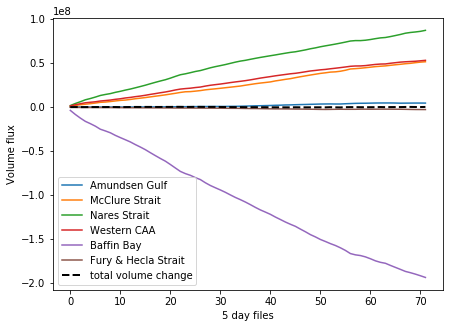

In [21]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.plot(np.cumsum(np.sum(-1*np.sum(time_series_V1,axis=2),axis=1)), label='Amundsen Gulf')
ax.plot(np.cumsum(np.sum(-1*np.sum(time_series_V2,axis=2),axis=1)), label='McClure Strait')
ax.plot(np.cumsum(np.sum(-1*np.sum(time_series_V7,axis=2),axis=1)), label='Nares Strait')
ax.plot(np.cumsum(np.sum(-1*(np.sum(time_series_V3,axis=2) + np.sum(time_series_V4,axis=2) + \
                             np.sum(time_series_V5,axis=2) + np.sum(time_series_V6,axis=2)),axis=1)), \
                               label='Western CAA')
ax.plot(np.cumsum(np.sum(np.sum(time_series_V8,axis=2),axis=1)), label='Baffin Bay')
ax.plot(np.cumsum(np.sum(np.sum(time_series_V9,axis=2),axis=1)), label='Fury & Hecla Strait')

ax.plot(np.cumsum(np.sum(sum_V,axis=1)),'--k', label='total volume change',linewidth=2)

ax.set_xlabel('5 day files')
ax.set_ylabel('Volume flux')
ax.legend()

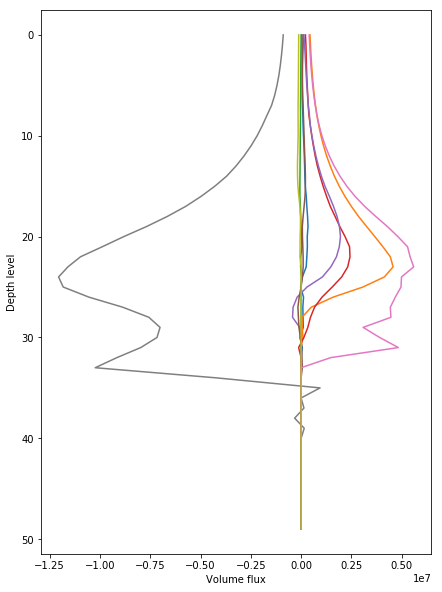

In [22]:
fig, ax = plt.subplots(1,1, figsize=(7,10))

ax.plot(-1*np.sum(np.sum(time_series_V1, axis=2),axis=0), np.arange(0,50))
ax.plot(-1*np.sum(np.sum(time_series_V2, axis=2),axis=0), np.arange(0,50))
ax.plot(-1*np.sum(np.sum(time_series_V3, axis=2),axis=0), np.arange(0,50))
ax.plot(-1*np.sum(np.sum(time_series_V4, axis=2),axis=0), np.arange(0,50))
ax.plot(-1*np.sum(np.sum(time_series_V5, axis=2),axis=0), np.arange(0,50))
ax.plot(-1*np.sum(np.sum(time_series_V6, axis=2),axis=0), np.arange(0,50))
ax.plot(-1*np.sum(np.sum(time_series_V7, axis=2),axis=0), np.arange(0,50))
ax.plot(np.sum(np.sum(time_series_V8, axis=2),axis=0), np.arange(0,50))
ax.plot(np.sum(np.sum(time_series_V9, axis=2),axis=0), np.arange(0,50))

ax.set_xlabel('Volume flux')
ax.set_ylabel('Depth level')
ax.invert_yaxis()

Combine some of the western boundary fluxes:

In [23]:
time_series_mn_WCAA = np.sum(np.sum(time_series_mn3,axis=2),axis=1) + \
                    np.sum(np.sum(time_series_mn4,axis=2),axis=1) + \
                    np.sum(np.sum(time_series_mn5,axis=2),axis=1) + \
                    np.sum(np.sum(time_series_mn6,axis=2),axis=1)

In [24]:
time_series_V_WCAA = np.sum(np.sum(time_series_V3,axis=2),axis=1) + \
                    np.sum(np.sum(time_series_V4,axis=2),axis=1) + \
                    np.sum(np.sum(time_series_V5,axis=2),axis=1) + \
                    np.sum(np.sum(time_series_V6,axis=2),axis=1)

### Time series across boundaries:

- Positive --- into domain
- Negative --- out of domain

In [25]:
file_dates = [dt.datetime.strptime(i[23:34], "y%Ym%md%d") for i in gridV_files]
bdy_colours = ['#386c82','#6e8bce','#992622','#f07440','#a0db8e','#672edf']

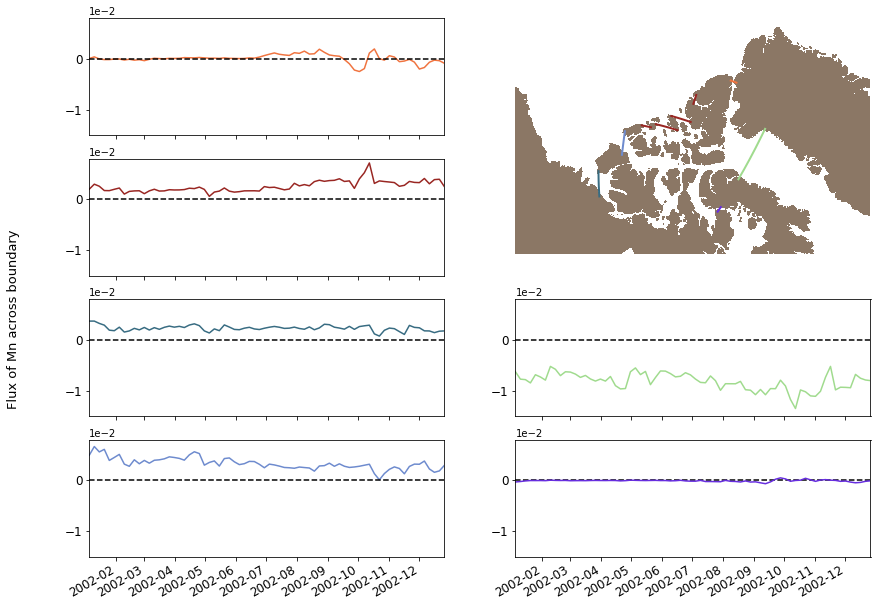

In [26]:
fig,ax = plt.subplots(4,2, figsize=(14,11))

fig.autofmt_xdate()

ax2 = plt.subplot2grid((2,2), (0,1), rowspan=1, colspan=2, frameon=False)

ax[0,1].set_visible(False)
ax[1,1].set_visible(False)

ax[0,0].get_xaxis().set_ticklabels([]);
ax[1,0].get_xaxis().set_ticklabels([]);
ax[2,0].get_xaxis().set_ticklabels([]);
ax[2,1].get_xaxis().set_ticklabels([]);

fig.text(0.05, 0.5, 'Flux of Mn across boundary',\
         ha='center', va='center', rotation='vertical', fontsize=13) #[mol/L 1/5day 1/area]

# Left 4 time series -- ---------------------------------------------------------
ax[0,0].plot(file_dates, -1*np.sum(np.sum(time_series_mn1,axis=2),axis=1), c=bdy_colours[3])
ax[1,0].plot(file_dates, -1*np.sum(np.sum(time_series_mn2,axis=2),axis=1), c=bdy_colours[2])
ax[2,0].plot(file_dates, -1*time_series_mn_WCAA, c=bdy_colours[0])
ax[3,0].plot(file_dates, -1*np.sum(np.sum(time_series_mn7,axis=2),axis=1), c=bdy_colours[1])

for axs in [ax[0,0], ax[1,0], ax[2,0], ax[3,0], ax[2,1], ax[3,1]]:
    axs.plot([file_dates[0], file_dates[-1]], [0, 0], '--k')
    axs.set_xlim([file_dates[0], file_dates[-1]])
    axs.set_ylim([-1.5e-2, 8e-3])
    axs.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    axs.tick_params(axis='both', which='major', labelsize=12)

# Right 2 time series -- ---------------------------------------------------------
ax[2,1].plot(file_dates, np.sum(np.sum(time_series_mn8,axis=2),axis=1), c=bdy_colours[4])
ax[3,1].plot(file_dates, np.sum(np.sum(time_series_mn9,axis=2),axis=1), c=bdy_colours[5])


# plot map in top right ---------------------------------------------------------
proj1=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -92, resolution='i', width=4.0e6, height=2.55e6, ax=ax2)
x_land, y_land = proj1(tlons, tlats)
proj1.contourf(x_land, y_land, land_mask[0,:,:], vmax=0.3, cmap=matplotlib.colors.ListedColormap(["#8b7765"]))

x_model, y_model = proj1(lons, lats)
proj1.plot(x_model[l1i, l1j[0]:l1j[-1]], y_model[l1i, l1j[0]:l1j[-1]],'-', c=bdy_colours[0], linewidth=2) 
proj1.plot(x_model[l2i, l2j[0]:l2j[-1]], y_model[l2i, l2j[0]:l2j[-1]],'-', c=bdy_colours[1], linewidth=2) 
proj1.plot(x_model[l3i[0]:l3i[-1], l3j], y_model[l3i[0]:l3i[-1], l3j],'-', c=bdy_colours[2], linewidth=2) 
proj1.plot(x_model[l4i[0]:l4i[-1], l4j], y_model[l4i[0]:l4i[-1], l4j],'-', c=bdy_colours[2], linewidth=2)
proj1.plot(x_model[l5i[0]:l5i[-1], l5j], y_model[l5i[0]:l5i[-1], l5j],'-', c=bdy_colours[2], linewidth=2)
proj1.plot(x_model[l6i, l6j[0]:l6j[-1]], y_model[l6i, l6j[0]:l6j[-1]],'-', c=bdy_colours[2], linewidth=2)
proj1.plot(x_model[t1i[0]:t1i[-1], t1j], y_model[t1i[0]:t1i[-1], t1j],'-', c=bdy_colours[3], linewidth=2) 
proj1.plot(x_model[r1i, r1j[0]:r1j[-1]], y_model[r1i, r1j[0]:r1j[-1]],'-', c=bdy_colours[4], linewidth=2) 
proj1.plot(x_model[r2i, r2j[0]:r2j[-1]], y_model[r2i, r2j[0]:r2j[-1]],'-', c=bdy_colours[5], linewidth=2) 

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/flux_time-series.png', bbox_inches='tight')

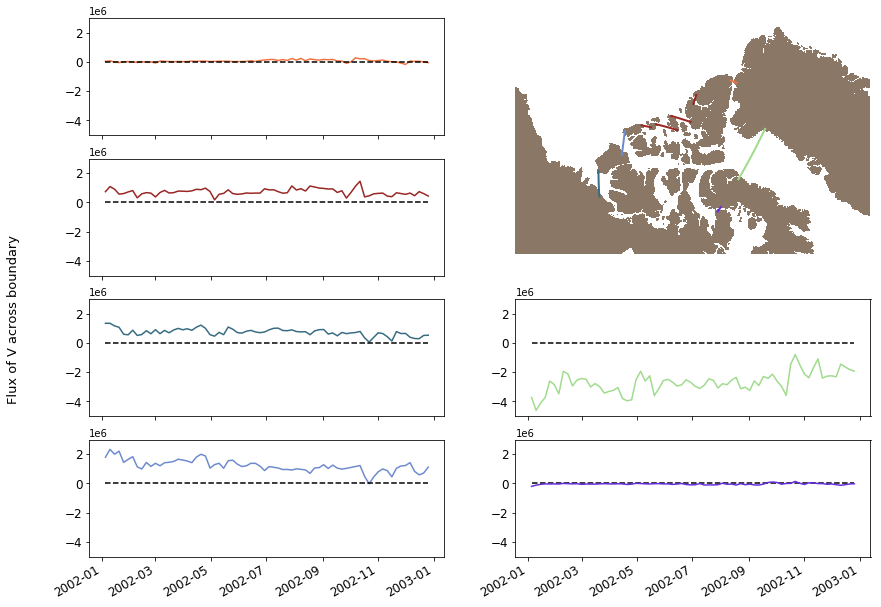

In [27]:
fig,ax = plt.subplots(4,2, figsize=(14,11))

fig.autofmt_xdate()

ax2 = plt.subplot2grid((2,2), (0,1), rowspan=1, colspan=2, frameon=False)

ax[0,1].set_visible(False)
ax[1,1].set_visible(False)

ax[0,0].get_xaxis().set_ticklabels([]);
ax[1,0].get_xaxis().set_ticklabels([]);
ax[2,0].get_xaxis().set_ticklabels([]);
ax[2,1].get_xaxis().set_ticklabels([]);

fig.text(0.05, 0.5, 'Flux of V across boundary',\
         ha='center', va='center', rotation='vertical', fontsize=13) #[mol/L 1/5day 1/area]

# Left 4 time series -- ---------------------------------------------------------
ax[0,0].plot(file_dates, -1*np.sum(np.sum(time_series_V1,axis=2),axis=1), c=bdy_colours[3])
ax[1,0].plot(file_dates, -1*np.sum(np.sum(time_series_V2,axis=2),axis=1), c=bdy_colours[2])
ax[2,0].plot(file_dates, -1*time_series_V_WCAA, c=bdy_colours[0])
ax[3,0].plot(file_dates, -1*np.sum(np.sum(time_series_V7,axis=2),axis=1), c=bdy_colours[1])

for axs in [ax[0,0], ax[1,0], ax[2,0], ax[3,0], ax[2,1], ax[3,1]]:
    axs.plot([file_dates[0], file_dates[-1]], [0, 0], '--k')
    axs.set_ylim([-5e6, 3e6])
    axs.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    axs.tick_params(axis='both', which='major', labelsize=12)

# Right 2 time series -- ---------------------------------------------------------
ax[2,1].plot(file_dates, np.sum(np.sum(time_series_V8,axis=2),axis=1), c=bdy_colours[4])
ax[3,1].plot(file_dates, np.sum(np.sum(time_series_V9,axis=2),axis=1), c=bdy_colours[5])


# plot map in top right ---------------------------------------------------------
proj1=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -92, resolution='i', width=4.0e6, height=2.55e6, ax=ax2)
x_land, y_land = proj1(tlons, tlats)
proj1.contourf(x_land, y_land, land_mask[0,:,:], vmax=0.3, cmap=matplotlib.colors.ListedColormap(["#8b7765"]))

x_model, y_model = proj1(lons, lats)
proj1.plot(x_model[l1i, l1j[0]:l1j[-1]], y_model[l1i, l1j[0]:l1j[-1]],'-', c=bdy_colours[0], linewidth=2) 
proj1.plot(x_model[l2i, l2j[0]:l2j[-1]], y_model[l2i, l2j[0]:l2j[-1]],'-', c=bdy_colours[1], linewidth=2) 
proj1.plot(x_model[l3i[0]:l3i[-1], l3j], y_model[l3i[0]:l3i[-1], l3j],'-', c=bdy_colours[2], linewidth=2) 
proj1.plot(x_model[l4i[0]:l4i[-1], l4j], y_model[l4i[0]:l4i[-1], l4j],'-', c=bdy_colours[2], linewidth=2)
proj1.plot(x_model[l5i[0]:l5i[-1], l5j], y_model[l5i[0]:l5i[-1], l5j],'-', c=bdy_colours[2], linewidth=2)
proj1.plot(x_model[l6i, l6j[0]:l6j[-1]], y_model[l6i, l6j[0]:l6j[-1]],'-', c=bdy_colours[2], linewidth=2)
proj1.plot(x_model[t1i[0]:t1i[-1], t1j], y_model[t1i[0]:t1i[-1], t1j],'-', c=bdy_colours[3], linewidth=2) 
proj1.plot(x_model[r1i, r1j[0]:r1j[-1]], y_model[r1i, r1j[0]:r1j[-1]],'-', c=bdy_colours[4], linewidth=2) 
proj1.plot(x_model[r2i, r2j[0]:r2j[-1]], y_model[r2i, r2j[0]:r2j[-1]],'-', c=bdy_colours[5], linewidth=2) 

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/flux_time-series.png', bbox_inches='tight')

Normalized volume and Mn flux to observe relative time series:

In [33]:
np.amax(time_series_mn_WCAA)

-0.0007219333272979744

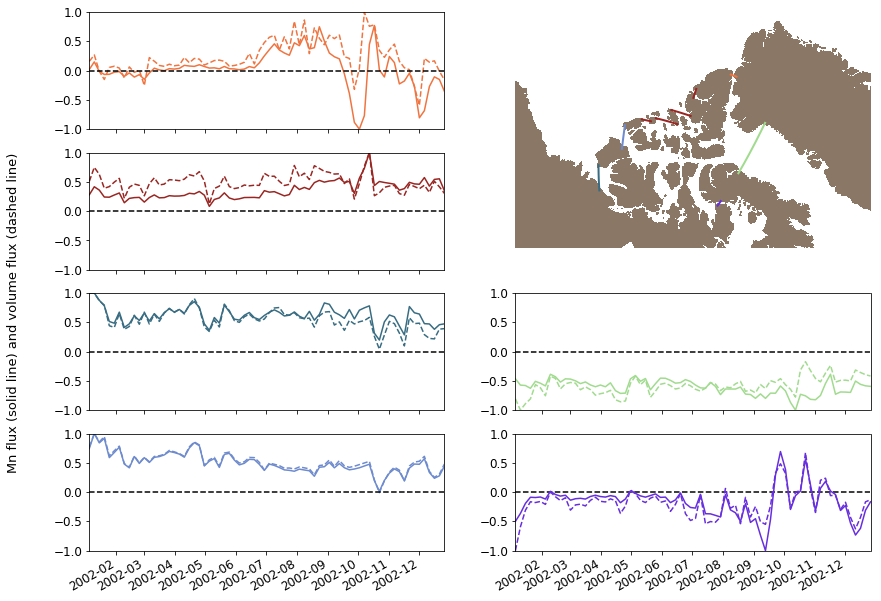

In [40]:
fig,ax = plt.subplots(4,2, figsize=(14,11))

fig.autofmt_xdate()

ax2 = plt.subplot2grid((2,2), (0,1), rowspan=1, colspan=2, frameon=False)

ax[0,1].set_visible(False)
ax[1,1].set_visible(False)

ax[0,0].get_xaxis().set_ticklabels([]);
ax[1,0].get_xaxis().set_ticklabels([]);
ax[2,0].get_xaxis().set_ticklabels([]);
ax[2,1].get_xaxis().set_ticklabels([]);

fig.text(0.05, 0.5, 'Mn flux (solid line) and volume flux (dashed line)',\
         ha='center', va='center', rotation='vertical', fontsize=13) #[mol/L 1/5day 1/area]

# Left 4 time series -- ---------------------------------------------------------
ax[0,0].plot(file_dates, -1*np.sum(np.sum(time_series_mn1,axis=2),axis=1)/ \
             np.amax(np.abs(np.sum(np.sum(time_series_mn1,axis=2),axis=1))), c=bdy_colours[3])
ax[0,0].plot(file_dates, -1*np.sum(np.sum(time_series_V1,axis=2),axis=1)/ \
             np.amax(np.abs(np.sum(np.sum(time_series_V1,axis=2),axis=1))), '--', c=bdy_colours[3])

ax[1,0].plot(file_dates, -1*np.sum(np.sum(time_series_mn2,axis=2),axis=1)/ \
             np.amax(np.abs(np.sum(np.sum(time_series_mn2,axis=2),axis=1))), c=bdy_colours[2])
ax[1,0].plot(file_dates, -1*np.sum(np.sum(time_series_V2,axis=2),axis=1)/ \
             np.amax(np.abs(np.sum(np.sum(time_series_V2,axis=2),axis=1))), '--', c=bdy_colours[2])


ax[2,0].plot(file_dates, -1*time_series_mn_WCAA/ \
             np.amax(np.abs(time_series_mn_WCAA)), c=bdy_colours[0])
ax[2,0].plot(file_dates, -1*time_series_V_WCAA/ \
             np.amax(np.abs(time_series_V_WCAA)), '--', c=bdy_colours[0])

ax[3,0].plot(file_dates, -1*np.sum(np.sum(time_series_mn7,axis=2),axis=1)/ \
             np.amax(np.abs(np.sum(np.sum(time_series_mn7,axis=2),axis=1))), c=bdy_colours[1])
ax[3,0].plot(file_dates, -1*np.sum(np.sum(time_series_V7,axis=2),axis=1)/ \
             np.amax(np.abs(np.sum(np.sum(time_series_V7,axis=2),axis=1))), '--', c=bdy_colours[1])


for axs in [ax[0,0], ax[1,0], ax[2,0], ax[3,0], ax[2,1], ax[3,1]]:
    axs.plot([file_dates[0], file_dates[-1]], [0, 0], '--k')
    axs.set_xlim([file_dates[0], file_dates[-1]])
    axs.set_ylim([-1, 1])
    axs.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    axs.tick_params(axis='both', which='major', labelsize=12)

# Right 2 time series -- ---------------------------------------------------------
ax[2,1].plot(file_dates, np.sum(np.sum(time_series_mn8,axis=2),axis=1)/ \
             np.amax(np.abs(np.sum(np.sum(time_series_mn8,axis=2),axis=1))), c=bdy_colours[4])
ax[3,1].plot(file_dates, np.sum(np.sum(time_series_mn9,axis=2),axis=1)/ \
             np.amax(np.abs(np.sum(np.sum(time_series_mn9,axis=2),axis=1))), c=bdy_colours[5])
ax[2,1].plot(file_dates, np.sum(np.sum(time_series_V8,axis=2),axis=1)/ \
             np.amax(np.abs(np.sum(np.sum(time_series_V8,axis=2),axis=1))), '--', c=bdy_colours[4])
ax[3,1].plot(file_dates, np.sum(np.sum(time_series_V9,axis=2),axis=1)/ \
             np.amax(np.abs(np.sum(np.sum(time_series_V9,axis=2),axis=1))), '--', c=bdy_colours[5])


# plot map in top right ---------------------------------------------------------
proj1=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -92, resolution='i', width=4.0e6, height=2.55e6, ax=ax2)
x_land, y_land = proj1(tlons, tlats)
proj1.contourf(x_land, y_land, land_mask[0,:,:], vmax=0.3, cmap=matplotlib.colors.ListedColormap(["#8b7765"]))

x_model, y_model = proj1(lons, lats)
proj1.plot(x_model[l1i, l1j[0]:l1j[-1]], y_model[l1i, l1j[0]:l1j[-1]],'-', c=bdy_colours[0], linewidth=2) 
proj1.plot(x_model[l2i, l2j[0]:l2j[-1]], y_model[l2i, l2j[0]:l2j[-1]],'-', c=bdy_colours[1], linewidth=2) 
proj1.plot(x_model[l3i[0]:l3i[-1], l3j], y_model[l3i[0]:l3i[-1], l3j],'-', c=bdy_colours[2], linewidth=2) 
proj1.plot(x_model[l4i[0]:l4i[-1], l4j], y_model[l4i[0]:l4i[-1], l4j],'-', c=bdy_colours[2], linewidth=2)
proj1.plot(x_model[l5i[0]:l5i[-1], l5j], y_model[l5i[0]:l5i[-1], l5j],'-', c=bdy_colours[2], linewidth=2)
proj1.plot(x_model[l6i, l6j[0]:l6j[-1]], y_model[l6i, l6j[0]:l6j[-1]],'-', c=bdy_colours[2], linewidth=2)
proj1.plot(x_model[t1i[0]:t1i[-1], t1j], y_model[t1i[0]:t1i[-1], t1j],'-', c=bdy_colours[3], linewidth=2) 
proj1.plot(x_model[r1i, r1j[0]:r1j[-1]], y_model[r1i, r1j[0]:r1j[-1]],'-', c=bdy_colours[4], linewidth=2) 
proj1.plot(x_model[r2i, r2j[0]:r2j[-1]], y_model[r2i, r2j[0]:r2j[-1]],'-', c=bdy_colours[5], linewidth=2) 

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/flux_time-series.png', bbox_inches='tight')

# Old functions

In [153]:
# call the function for each file that is within range of start date, end date
a = len(gridV_files)
time_series_mn1 = np.empty((a, 50, l1j.size-1)); time_series_mn2 = np.empty((a, 50, l2j.size-1)); 
time_series_mn3 = np.empty((a, 50, l3i.size-1)); time_series_mn4 = np.empty((a, 50, l4i.size-1)); 
time_series_mn5 = np.empty((a, 50, l5i.size-1)); time_series_mn6 = np.empty((a, 50, l6j.size-1)); 
time_series_mn7 = np.empty((a, 50, t1i.size-1)); time_series_mn8 = np.empty((a, 50, r1j.size-1)); 
time_series_mn9 = np.empty((a, 50, r2j.size-1)); 

time_series_V1 = np.empty_like(time_series_mn1); time_series_V2 = np.empty_like(time_series_mn2); 
time_series_V3 = np.empty_like(time_series_mn3); time_series_V4 = np.empty_like(time_series_mn4); 
time_series_V5 = np.empty_like(time_series_mn5); time_series_V6 = np.empty_like(time_series_mn6); 
time_series_V7 = np.empty_like(time_series_mn7); time_series_V8 = np.empty_like(time_series_mn8); 
time_series_V9 = np.empty_like(time_series_mn9); 

gridV_files = np.array(gridV_files)

for i in range(0,a):
    flx_mnl1, flx_mnl2, flx_mnl3, flx_mnl4, flx_mnl5, \
    flx_mnl6, flx_mnt1, flx_mnr1, flx_mnr2, flx_Vl1, \
    flx_Vl2, flx_Vl3, flx_Vl4, flx_Vl5, flx_Vl6, \
    flx_Vt1, flx_Vr1, flx_Vr2 = main_calc(gridU_files[i], gridV_files[i], gridP_files[i]) 
    
    time_series_mn1[i,:,:] = flx_mnl1
    time_series_mn2[i,:,:] = flx_mnl2
    time_series_mn3[i,:,:] = flx_mnl3
    time_series_mn4[i,:,:] = flx_mnl4
    time_series_mn5[i,:,:] = flx_mnl5
    time_series_mn6[i,:,:] = flx_mnl6
    time_series_mn7[i,:,:] = flx_mnt1
    time_series_mn8[i,:,:] = flx_mnr1
    time_series_mn9[i,:,:] = flx_mnr2
    
    time_series_V1[i,:,:] = flx_Vl1
    time_series_V2[i,:,:] = flx_Vl2
    time_series_V3[i,:,:] = flx_Vl3
    time_series_V4[i,:,:] = flx_Vl4
    time_series_V5[i,:,:] = flx_Vl5
    time_series_V6[i,:,:] = flx_Vl6
    time_series_V7[i,:,:] = flx_Vt1
    time_series_V8[i,:,:] = flx_Vr1
    time_series_V9[i,:,:] = flx_Vr2

In [ ]:
def calc_flux_bdy(bdy, u_vel, v_vel, vel_bdy, dmn, switch): 
    flux_bdy = 0
    
    # for each depth:
    for z in range(0, 50):
        # for each of the points in the boundary:
        for pt in range(0, len(bdy[0])):
            bdyx = int(bdy[0][pt])
            bdyy = int(bdy[1][pt])
            uvel = u_vel[z, bdyx, bdyy] 
            vvel = v_vel[z, bdyx, bdyy] 
            
            # Make sure that the sign of the flux is correct
            # --- into domain is positive
            # --- out of domain is negative
            if switch == 'W':
                if vvel > 0:   # dMn leaves domain
                    flux_bdy = flux_bdy - np.multiply(dmn[z, bdyx, bdyy], vel_bdy[z, pt])
                elif vvel < 0: # dMn enters domain
                    flux_bdy = flux_bdy + np.multiply(dmn[z, bdyx, bdyy], vel_bdy[z, pt])
            elif switch == 'N':
                if uvel < 0:
                    flux_bdy = flux_bdy + np.multiply(dmn[z, bdyx, bdyy], vel_bdy[z, pt])
                elif uvel > 0: 
                    flux_bdy = flux_bdy - np.multiply(dmn[z, bdyx, bdyy], vel_bdy[z, pt])
            elif switch == 'E':
                if vvel > 0:  
                    flux_bdy = flux_bdy + np.multiply(dmn[z, bdyx, bdyy], vel_bdy[z, pt])
                elif vvel < 0:
                    flux_bdy = flux_bdy - np.multiply(dmn[z, bdyx, bdyy], vel_bdy[z, pt])                
            
    return flux_bdy

In [ ]:
def calc_vel(bdy, u_vel, v_vel):
    ## Calculate velocity vector: consider using a dot product instead
    x_bdy = bdy[0]
    y_bdy = bdy[1]
    
    vel = np.zeros((50, len(x_bdy)))
    for i in range(0, len(x_bdy)):
        u = u_vel[:, int(x_bdy[i]), int(y_bdy[i])]
        v = v_vel[:, int(x_bdy[i]), int(y_bdy[i])]
        vel[:,i] = np.sqrt(u**2 + v**2)
            
    return vel